# Polar Format Algorithm

### Examples
#### Point Target

In [1]:
from sys import float_info

import numpy as np
import scipy
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.fft import ifft, fft, fftshift, ifftshift, fftfreq
from scipy.fft import ifft2, fft2
from scipy.constants import pi, c

In [2]:
from point_target import PointTargetKSpace

In [3]:
bandwidth       = 300e6
start_frequency = 5e9
range_to_center = 1000

x_target_pos = [-10, 0, 10]
y_target_pos = [10, 0, -10]
target_rcs   = [10, 10, 10]

image_dimensions = (100, 100)
image_bins       = (500, 500)
azimuth_span     = (-3, 3)

In [4]:
target = PointTargetKSpace(
    range_to_center,
    x_target_pos,
    y_target_pos,
    target_rcs,
    image_dimensions,
    image_bins,
    azimuth_span,
    start_frequency,
    bandwidth
)

In [5]:
fft_length = image_bins[0]

In [6]:
k = 2 * pi / target.wavelength

In [7]:
start_az = np.radians(0)
end_az = np.radians(45)

sensor_az = []
i = 0
index = []
for az in target.azimuths:
    if az >= start_az and az <= end_az:
        index.append(i)
        sensor_az.append(az)
        i += 1
signal = target.signal[:, index]

In [8]:
k_x = target.kx[:, index]
k_y = target.ky[:, index]

In [9]:
kx = np.linspace(np.min(k_x), np.max(k_x))
ky = np.linspace(np.min(k_y), np.max(k_y))
kx_grid, ky_grid = np.meshgrid(kx, ky)

In [16]:
signal_interp = scipy.interpolate.griddata((k_x.ravel(), k_y.ravel()), signal.ravel(), (kx_grid, ky_grid), method='linear', fill_value=(0+0j))

In [19]:
img = fftshift(fftshift(ifft2(signal_interp, (fft_length, fft_length)), 0), 1).transpose()

In [20]:
norm = 10 * np.log10(np.abs(img) / np.max(np.abs(img)))

In [21]:
freq_step_y = c / (2 * pi) * (kx_grid[0,1] - kx_grid[0,0])
range_extent_y = c / (2 * freq_step_y)
freq_step_x = c / (2 * pi) * (ky_grid[1,0] - ky_grid[0,0])
range_extent_x = c / (2 * freq_step_x)

In [22]:
x_rng = np.linspace(-0.5 * range_extent_x, 0.5 * range_extent_x, fft_length)
y_rng = np.linspace(-0.5 * range_extent_y, 0.5 * range_extent_y, fft_length)

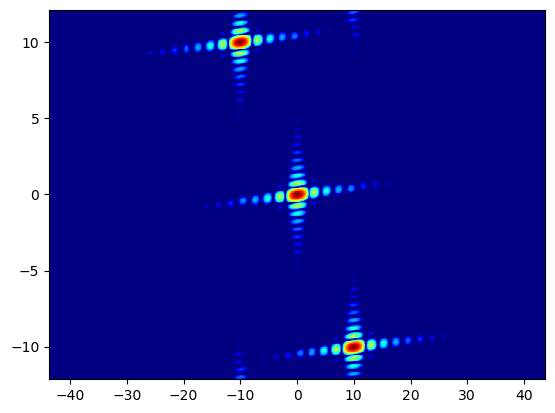

In [23]:
plt.pcolor(x_rng, y_rng, norm, cmap='jet', vmin=-15)